## Analyses descriptives des données "Open Food Facts"


In [381]:
# importation des librairies nécessaires

import warnings
warnings.filterwarnings("ignore")
import os
import matplotlib
import numpy as np
import pandas as pd
import scipy.stats as stats
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Fonctions outils

In [382]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

def plot_dendrogram(Z, names):
    plt.figure(figsize=(10,25))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    plt.show()

# Chargement des données


In [491]:
# importation du jeu de données
filename = "openfoodfacts_clean_data.csv"
df = pd.read_csv(filename, decimal = ',')
df.head(3)

,code,product_name,brands,categories,countries_en,additives_n,ingredients_that_may_be_from_palm_oil_n,nutriscore_grade,nova_group,pnns_groups_1,...,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g,sum_ingredients
0,3660088110779,Sardines sans arêtes à l’huile d’olive,LA BELLE ILOISE,"Conserves, Produits de la mer, Poissons, Poiss...",France,0.0,0.0,d,3.0,Fish Meat Eggs,...,341.0,28.1,5.54,0.2,0.2,21.5,0.7,18.8,12.0,50.7
1,3263851162212,Moutarde miel,Franprix,"Epicerie, Condiments, Sauces, Moutardes, Mouta...",France,0.0,0.0,e,3.0,Fat and sauces,...,872.0,14.39999961853,0.89999997615814,9.8999996185303,9.6999998092651,6.5,5.4000000953674,0.0,19.0,45.8999991416928
2,3263851162311,Moutarde moût de raisin,Franprix,"Epicerie, Condiments, Sauces, Moutardes",France,0.0,0.0,d,3.0,Fat and sauces,...,216.0,7.3,2.2,29.1,23.0,5.1,4.7,4.2,16.0,69.19999999999999


In [492]:
df.shape

(1218586, 23)

In [493]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218586 entries, 0 to 1218585
Data columns (total 23 columns):
 #   Column                                                 Non-Null Count    Dtype 
---  ------                                                 --------------    ----- 
 0   code                                                   1218586 non-null  object
 1   product_name                                           1218586 non-null  object
 2   brands                                                 1218586 non-null  object
 3   categories                                             1218586 non-null  object
 4   countries_en                                           1218586 non-null  object
 5   additives_n                                            1218586 non-null  object
 6   ingredients_that_may_be_from_palm_oil_n                1218586 non-null  object
 7   nutriscore_grade                                       470754 non-null   object
 8   nova_group                      

In [494]:
# modification des types du dataset en float quand cela est nécessaire
col_name = ["nova_group", "ingredients_that_may_be_from_palm_oil_n", "additives_n", "energy-kcal_100g", "fat_100g", "saturated-fat_100g", "carbohydrates_100g", "sugars_100g", "proteins_100g", "salt_100g", "fruits-vegetables-nuts-estimate-from-ingredients_100g", "nutrition-score-fr_100g"]
for col in col_name:
    df[col] = pd.to_numeric(df[col])

In [495]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218586 entries, 0 to 1218585
Data columns (total 23 columns):
 #   Column                                                 Non-Null Count    Dtype  
---  ------                                                 --------------    -----  
 0   code                                                   1218586 non-null  object 
 1   product_name                                           1218586 non-null  object 
 2   brands                                                 1218586 non-null  object 
 3   categories                                             1218586 non-null  object 
 4   countries_en                                           1218586 non-null  object 
 5   additives_n                                            1218586 non-null  float64
 6   ingredients_that_may_be_from_palm_oil_n                1218586 non-null  float64
 7   nutriscore_grade                                       470754 non-null   object 
 8   nova_group            

In [496]:
'''ind_nutris = ['energy-kcal_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g', 'nutrition-score-fr_100g']
for ind in ind_nutris:
    if ind == 'energy-kcal_100g':
        filter = df[ind].isna() | ((df[ind] > 0) & (df[ind] <= 900))
    else:
        filter = df[ind].isna() | ((df[ind] > 0) & (df[ind] <= 100))
    df = df[filter]

df.shape'''

"ind_nutris = ['energy-kcal_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g', 'nutrition-score-fr_100g']\nfor ind in ind_nutris:\n    if ind == 'energy-kcal_100g':\n        filter = df[ind].isna() | ((df[ind] > 0) & (df[ind] <= 900))\n    else:\n        filter = df[ind].isna() | ((df[ind] > 0) & (df[ind] <= 100))\n    df = df[filter]\n\ndf.shape"

In [497]:
# Supprimer des outliers les valeurs pour 100g
#cols = ['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',  'proteins_100g', 'salt_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g', 'nutrition-score-fr_100g']

#for col in cols : 
#    line = df.loc[(df[col] < 0)].index.to_list()
#    df.drop(index=line, inplace=True)

#df.shape

# Analyses univariées

On va réaliser une analyse univariée de nos différentes variables pour voir leur comportement. On va commencer par les variables catégorielles et après les variables quantitatives. Attention, puisque on a pas mal des produits sans catégories (unknown) donc d'abord on limit des valeurs unknown et après on fait des digrammes pour les valeurs.

In [391]:
print('Nombre de produits :', len(df['product_name']))


Nombre de produits : 1218586


<AxesSubplot:title={'center':'Classement des produits catégorie pnns_groups_2 les plus présentes dans nos données'}>

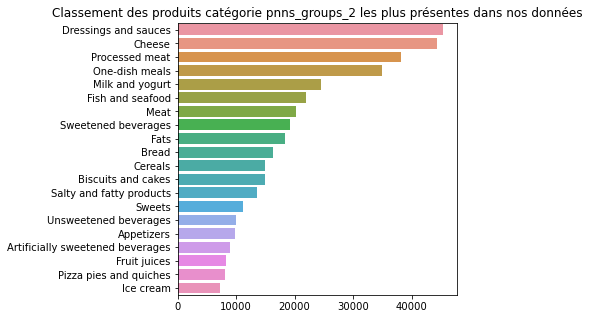

In [392]:
# countplot répartition des produits par 20 top pnns2
plt.figure(figsize=(5,5))
df_select = df[df['pnns_groups_2'] != 'unknown']
top_pnns2 = df_select['pnns_groups_2'].value_counts().head(20)
plt.title('Classement des produits catégorie pnns_groups_2 les plus présentes dans nos données')
sns.barplot(x=top_pnns2.values, y=top_pnns2.index)

<AxesSubplot:title={'center':'Classement des produits catégorie pnns_groups_1 les plus présentes dans nos données'}>

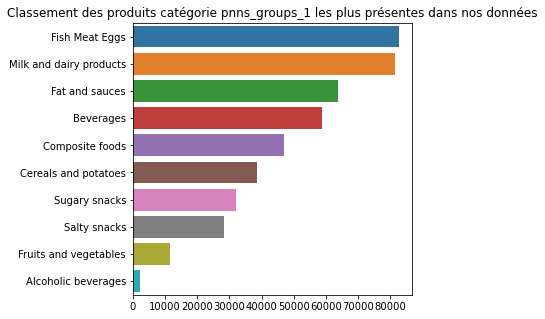

In [393]:
# countplot répartition des produits par 20 top pnns1
plt.figure(figsize=(5,5))
df_select = df[df['pnns_groups_1'] != 'unknown']
top_pnns1 = df_select['pnns_groups_1'].value_counts().head(20)
plt.title('Classement des produits catégorie pnns_groups_1 les plus présentes dans nos données')
sns.barplot(x=top_pnns1.values, y=top_pnns1.index)

<AxesSubplot:title={'center':'Classement des product_name les plus présentes dans nos données'}>

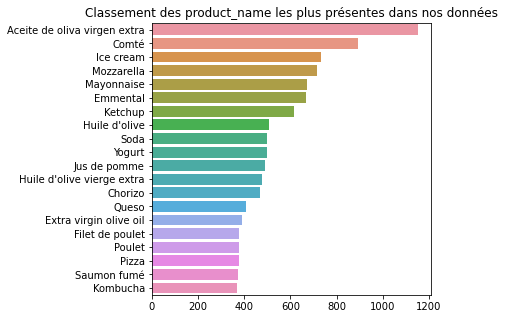

In [394]:
# countplot répartition des produits par 20 top product_name
plt.figure(figsize=(5,5))
df_select = df[df['product_name'] != 'unknown']
top_produit = df_select['product_name'].value_counts().head(20)
plt.title('Classement des product_name les plus présentes dans nos données')
sns.barplot(x=top_produit.values, y=top_produit.index)

la majorité des produit sont des Dressings and sauces et chesse et processed meat et Fish meat Eggs et Milk.

In [395]:
print('Nombre de marques :', len(df['brands'].unique()))

Nombre de marques : 109050


<AxesSubplot:title={'center':'Classement des marques les plus représentées dans nos données'}>

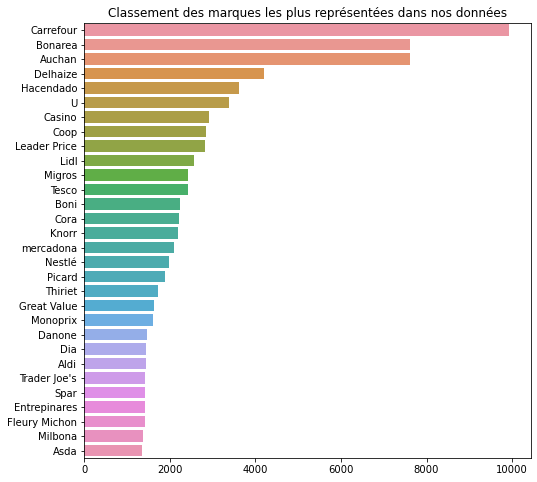

In [396]:
# countplot répartition des produits par 30 top marques
plt.figure(figsize=(8,8))
df_select = df[df['brands'] != 'unknown']
top_brands = df_select['brands'].value_counts().head(30)
plt.title('Classement des marques les plus représentées dans nos données')
sns.barplot(x=top_brands.values, y=top_brands.index)

On voit les 2 top marques qui sont carrefour ,Auchan .

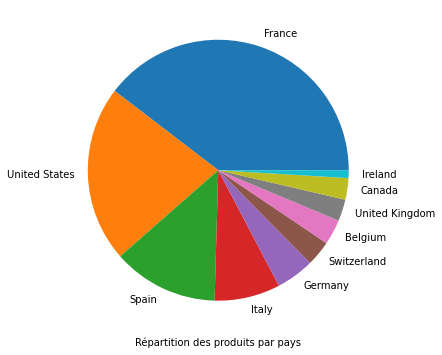

In [397]:
# piechart répartition des produits par 10 top pays
top_pays = df["countries_en"].value_counts().head(10)
values= top_pays.values
names = top_pays.index
plt.rcParams["figure.figsize"] = (25,6)
plt.pie(values,labels=names, labeldistance=1.10)
plt.xlabel("Répartition des produits par pays")
plt.show()


La plupart des produits sont destinés à la France et aux États-Unis et Espagne (Les pays européens).

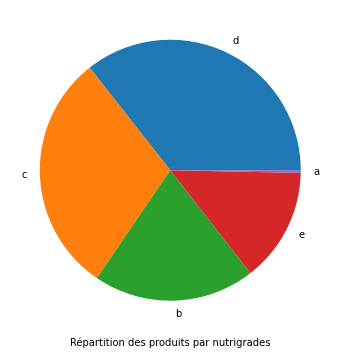

In [398]:
# piechart répartition des produits par nutrigrades
top_nutrigrades = df["nutriscore_grade"].value_counts()
values= top_nutrigrades.values
names = top_nutrigrades.index
plt.rcParams["figure.figsize"] = (25,6)
plt.xlabel("Répartition des produits par nutrigrades")
plt.pie(values,labels=names, labeldistance=1.10)
plt.show()

La plupart des produits sont dans la catégorie de nutrigrade D et C et B.

# Analyse bivariée 

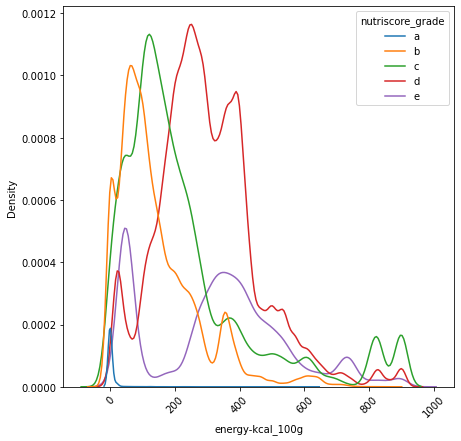

<Figure size 504x504 with 0 Axes>

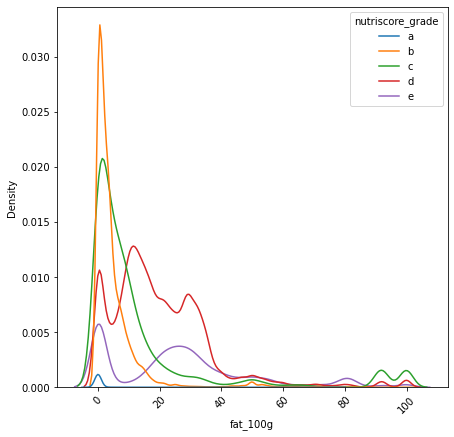

<Figure size 504x504 with 0 Axes>

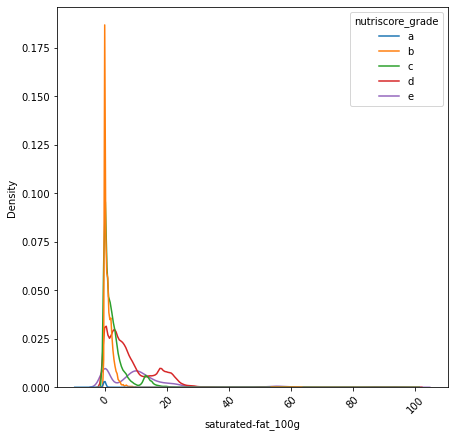

<Figure size 504x504 with 0 Axes>

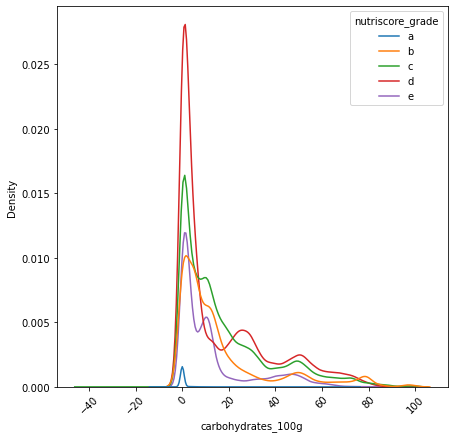

<Figure size 504x504 with 0 Axes>

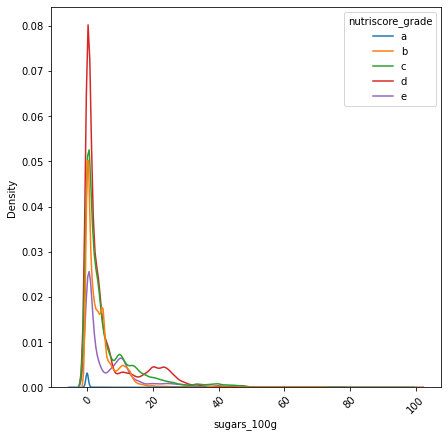

<Figure size 504x504 with 0 Axes>

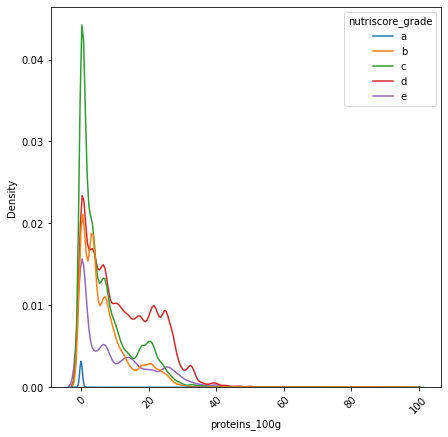

<Figure size 504x504 with 0 Axes>

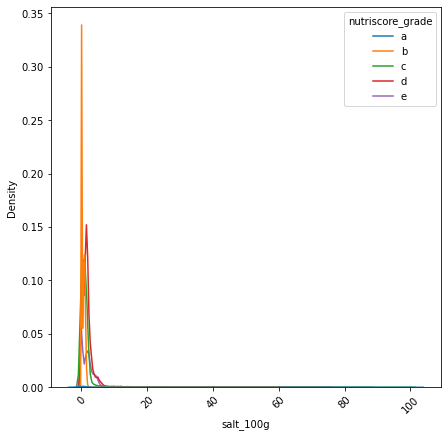

<Figure size 504x504 with 0 Axes>

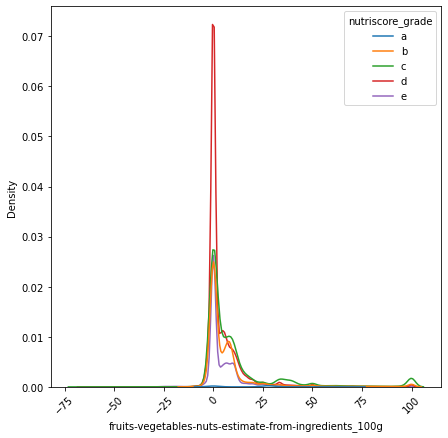

<Figure size 504x504 with 0 Axes>

In [399]:
# kdeplot pour visualiser la distribution des _100g en fonction du nutrigrade
col_nutr = ['energy-kcal_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g']
for col in col_nutr:
    plt.figure(figsize=(7,7))
    sns.kdeplot(data=df, hue= "nutriscore_grade", x = col, hue_order=['a', 'b', 'c', 'd', 'e'])
    plt.xlabel(col)
    plt.xticks(rotation=45)
    plt.figure(figsize=(7,7))
    plt.show()


On vas montrer l'influence des variables cibles (fat , sel, carboh, additif, sugar) sur le nutrigrade

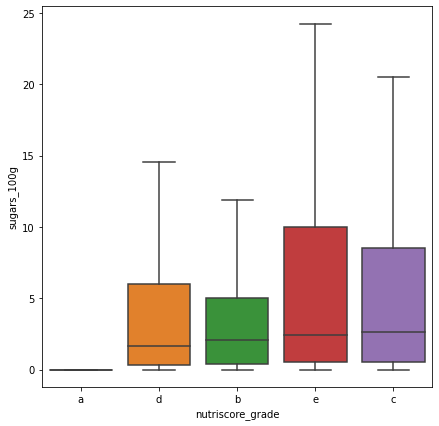

In [400]:
# grouped boxplot influence du nutrigrade sur le sucre
ordre_nutrigrade = df.groupby('nutriscore_grade')['sugars_100g'].median().sort_values().index

plt.figure(figsize=(7,7))
sns.boxplot(y="sugars_100g", x="nutriscore_grade", showfliers=False, order=ordre_nutrigrade, data=df);

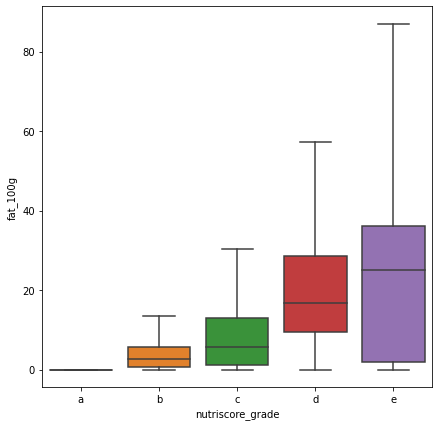

In [401]:
# grouped boxplot influence du nutrigrade sur le fat 
ordre_nutrigrade = df.groupby('nutriscore_grade')['fat_100g'].median().sort_values().index

plt.figure(figsize=(7,7))
sns.boxplot(y="fat_100g", x="nutriscore_grade", showfliers=False, order=ordre_nutrigrade, data=df);

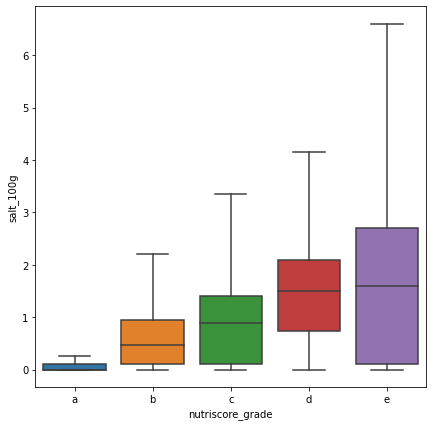

In [402]:
# grouped boxplot influence du nutrigrade sur le salt 
ordre_nutrigrade = df.groupby('nutriscore_grade')['salt_100g'].median().sort_values().index

plt.figure(figsize=(7,7))
sns.boxplot(y="salt_100g", x="nutriscore_grade", showfliers=False, order=ordre_nutrigrade, data=df);

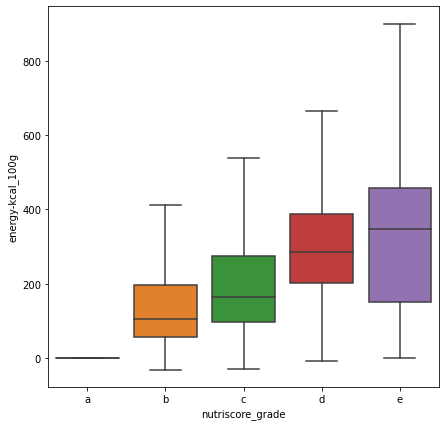

In [403]:
# grouped boxplot influence du nutrigrade sur l'energy
ordre_nutrigrade = df.groupby('nutriscore_grade')['energy-kcal_100g'].median().sort_values().index

plt.figure(figsize=(7,7))
sns.boxplot(y="energy-kcal_100g", x="nutriscore_grade", showfliers=False, order=ordre_nutrigrade, data=df);

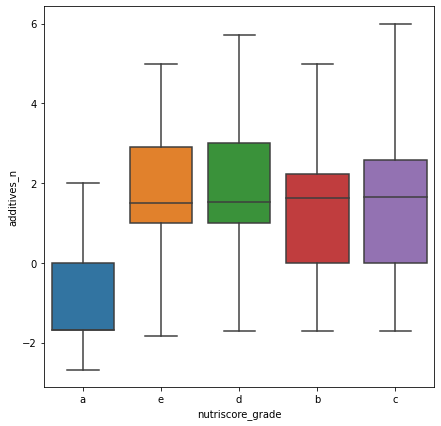

In [404]:
# grouped boxplot influence du nutrigrade sur additives_n
ordre_nutrigrade = df.groupby('nutriscore_grade')['additives_n'].median().sort_values().index

plt.figure(figsize=(7,7))
sns.boxplot(y="additives_n", x="nutriscore_grade", showfliers=False, order=ordre_nutrigrade, data=df);

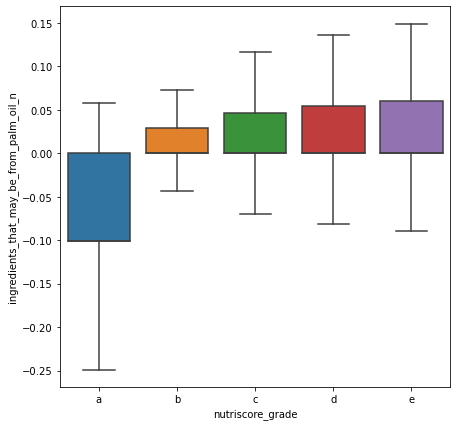

In [405]:
# grouped boxplot influence du nutrigrade sur ingredients_that_may_be_from_palm_oil_n
ordre_nutrigrade = df.groupby('nutriscore_grade')['ingredients_that_may_be_from_palm_oil_n'].median().sort_values().index

plt.figure(figsize=(7,7))
sns.boxplot(y="ingredients_that_may_be_from_palm_oil_n", x="nutriscore_grade", showfliers=False, order=ordre_nutrigrade, data=df);

la plupart de notre jeu de données sont les produits avec plus sucre, plus fat et salt et donc plus enrergy dan nutriscore D et C et B . En plus, la quantité d'ingrédients en lien avec l'huile de palme et le nombre d'additifs ont un impact sur la composition nutrionnelle des aliments ainsi que l'énergie contenue dans ces aliments.

<AxesSubplot:xlabel='count', ylabel='pnns_groups_1'>

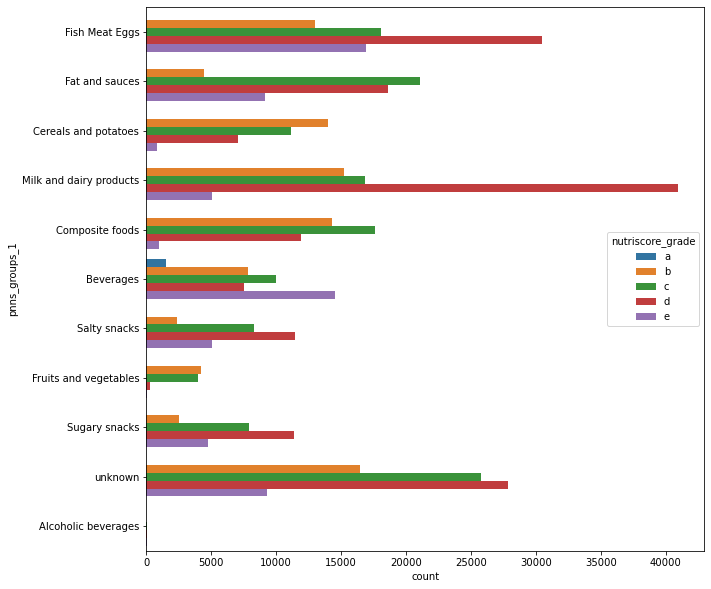

In [406]:
# countplot répartition des produits par catégories + nutrigrade
ordre_categorie = df.groupby('nutriscore_grade')['pnns_groups_1'].count().sort_values()
plt.figure(figsize=(10,10))
sns.countplot(y="pnns_groups_1", hue="nutriscore_grade", hue_order=['a', 'b', 'c', 'd', 'e'], data=df)

<AxesSubplot:xlabel='count', ylabel='pnns_groups_2'>

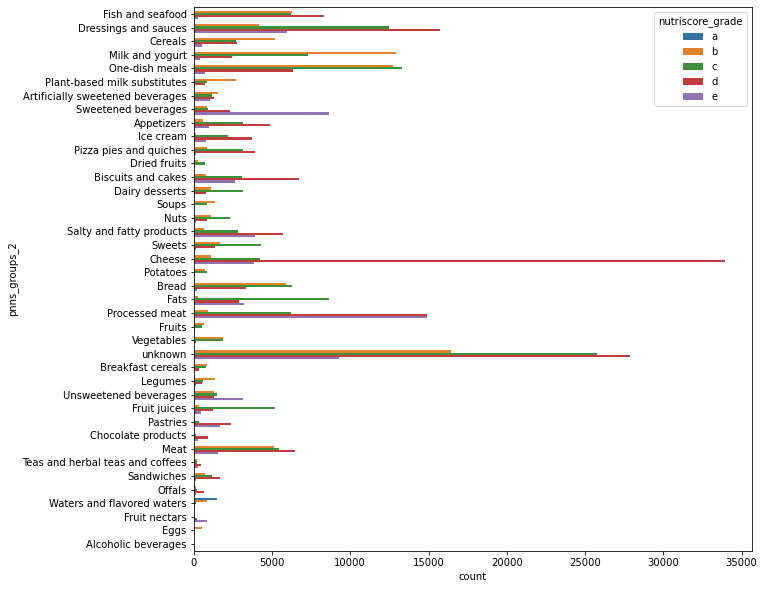

In [407]:
ordre_categorie = df.groupby('nutriscore_grade')['pnns_groups_2'].count().sort_values()
plt.figure(figsize=(10,10))
sns.countplot(y="pnns_groups_2", hue="nutriscore_grade", data=df, hue_order=['a', 'b', 'c', 'd', 'e'])

# L'idée d'application

On a envie de présenter une application qui nous aide pour trouver les produits avec moins des salt, suger, fat et donc moin energy. Cette application aide des diabetiques et des patients avec tension pour trouver les produits avec moins sucre et salt et aussi moins gras. On va tester si l'utilisation des données en lien avec les valeurs nutrionnelles du produit, l'énergie et sa composition comme fat suger et salt peuvent être intéressantes à utiliser pour développer un score global que l'on pourra imputer à d'autres aliments

In [408]:
df.describe()

,additives_n,ingredients_that_may_be_from_palm_oil_n,nova_group,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g
count,1.218586e+06,1.218586e+06,1.218586e+06,1.218586e+06,1.218586e+06,1.218586e+06,1.218586e+06,1.218586e+06,1.218586e+06,1.218586e+06,1.218586e+06,470758.000000
mean,2.012271e+00,7.298387e-02,3.485671e+00,2.330957e+02,1.328233e+01,4.608672e+00,1.787953e+01,5.096126e+00,9.315419e+00,1.574294e+00,6.892603e+00,9.487422
std,1.725731e+00,1.964046e-01,5.066835e-01,1.859518e+02,1.835799e+01,7.550458e+00,2.144374e+01,7.634707e+00,1.073602e+01,4.579890e+00,1.273040e+01,6.842002
min,-2.675615e+00,-3.226280e-01,1.000000e+00,-8.525165e+01,-3.703086e+01,-1.952600e+01,-1.200220e+02,-1.448867e+01,-3.391570e+01,-3.344117e+00,-7.334109e+01,0.000000
25%,1.357238e+00,0.000000e+00,3.371457e+00,8.200000e+01,8.800000e-01,1.200000e-01,1.700000e+00,5.000000e-01,1.000000e+00,1.250000e-01,0.000000e+00,3.000000
50%,1.795331e+00,3.377635e-02,3.502307e+00,2.000000e+02,6.340000e+00,1.785714e+00,9.000000e+00,2.000000e+00,6.100000e+00,1.000000e+00,4.701913e+00,10.000000
75%,2.418128e+00,8.064927e-02,3.756646e+00,3.500000e+02,1.900000e+01,6.000000e+00,2.638889e+01,6.500000e+00,1.429000e+01,1.707822e+00,8.950836e+00,15.000000
max,3.900000e+01,6.000000e+00,5.082828e+00,9.451430e+02,1.330727e+02,1.000000e+02,1.063306e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,37.000000


<

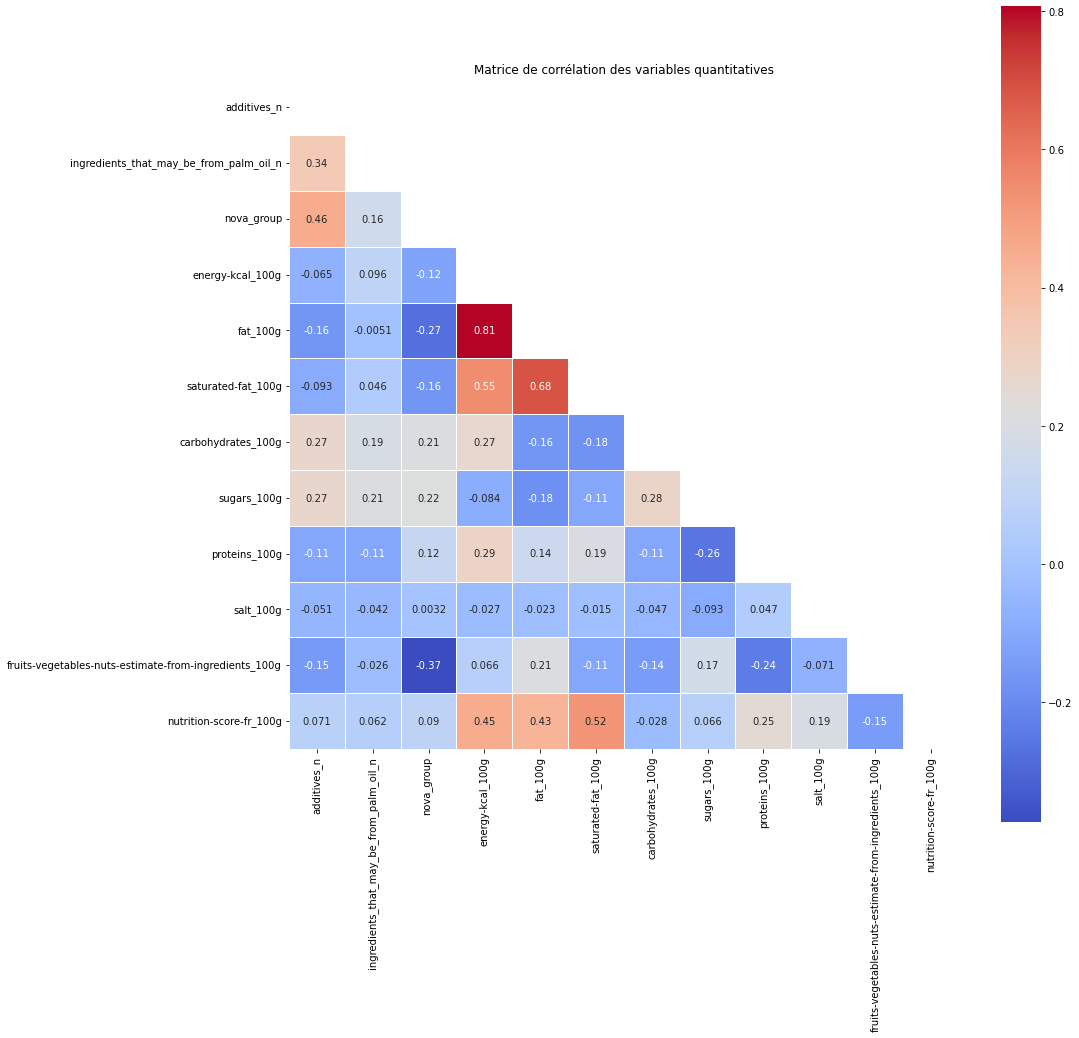

In [409]:
corr_matrix = df.corr()
mask = np.triu(corr_matrix)

plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, cmap="coolwarm", mask=mask, linewidths=.5, annot=True, cbar=True, square=True)
plt.title("Matrice de corrélation des variables quantitatives")
plt.show()

On remarque une forte corrélation positive entre la quantité d'énergie en kcal pour 100g et la quantité de graisses pour 100g (0.83), la quantité de graisses saturées pour 100g (0.54) et la quantité de carbohydrates pour 100g (0.34). De plus, on remarque une forte corrélation positive entre la quantité de graisses pour 100g et la quantité de graisses saturées pour 100g (0.66). Enfin, on observe une dernière corrélation positive moyenne entre la nutrotion score pour 100g et la quantité de graisses saturées pour 100g(0.62) et la quantité d'énergie en kcal pour 100g (0.56) et la quantité de graisses pour 100g (0.56).

### Analyse de régression entre variables quantitatives: 
On va donc réaliser une régression linéaire en partant de ces corrélations pour mieux voir ce qui unit ces variables

In [450]:
for ind in ind_nutris:
    if ind == 'energy-kcal_100g':
        filter = df[ind].isna() | ((df[ind] > 0) & (df[ind] <= 900))
    else:
        filter = df[ind].isna() | ((df[ind] > 0) & (df[ind] <= 100))
    df2 = df[filter]

df2.shape

(1054563, 31)

#### - Energie en Kcal et quantité de graisses pour 100g

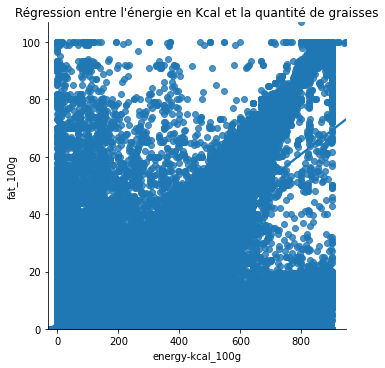

In [456]:
sns.lmplot(x="energy-kcal_100g", y="fat_100g", data=df2)
plt.title("Régression entre l'énergie en Kcal et la quantité de graisses")
plt.xlim(df2["energy-kcal_100g"].min(), df2["energy-kcal_100g"].max())
plt.ylim(df2["fat_100g"].min(), df2["fat_100g"].max())
plt.show()

In [457]:
pg.linear_regression(X=df2["energy-kcal_100g"], y=df2["fat_100g"], add_intercept=True, alpha=0.05)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-5.068384,0.015199,-333.467242,0.0,0.703062,0.703062,-5.098174,-5.038595
1,energy-kcal_100g,0.082542,0.000052,1580.154718,0.0,0.703062,0.703062,0.082440,0.082645


#### - Energie en Kcal et  quantité de graisses saturées pour 100g

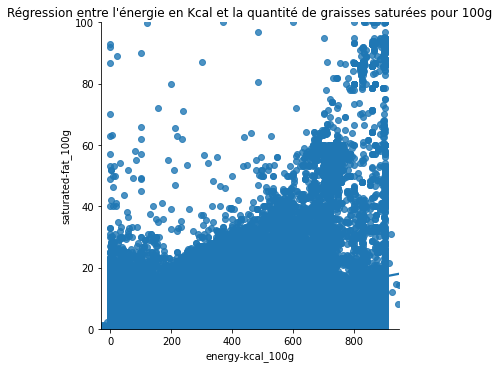

In [458]:
sns.lmplot(x="energy-kcal_100g", y="saturated-fat_100g", data=df2)
plt.title("Régression entre l'énergie en Kcal et la quantité de graisses saturées pour 100g")
plt.xlim(df2["energy-kcal_100g"].min(), df2["energy-kcal_100g"].max())
plt.ylim(df2["saturated-fat_100g"].min(), df2["saturated-fat_100g"].max())
plt.show()

In [459]:
pg.linear_regression(X=df2["energy-kcal_100g"], y=df2["saturated-fat_100g"], add_intercept=True, alpha=0.05)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-0.105965,0.007790,-13.602213,3.916995e-42,0.325552,0.325552,-0.121234,-0.090697
1,energy-kcal_100g,0.019102,0.000027,713.463922,0.000000e+00,0.325552,0.325552,0.019050,0.019155


#### -  La quantité de graisses saturées pour 100g et quantité de graisses pour 100g

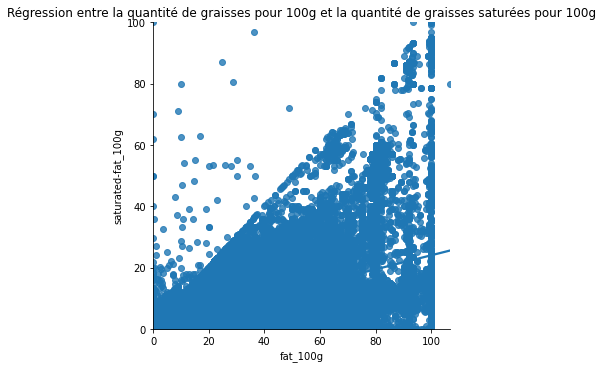

In [460]:
sns.lmplot(x="fat_100g", y="saturated-fat_100g", data=df2)
plt.title("Régression entre la quantité de graisses pour 100g et la quantité de graisses saturées pour 100g")
plt.xlim(df2["fat_100g"].min(), df2["fat_100g"].max())
plt.ylim(df2["saturated-fat_100g"].min(), df2["saturated-fat_100g"].max())
plt.show()

In [461]:
pg.linear_regression(X=df2["fat_100g"], y=df2["saturated-fat_100g"], add_intercept=True, alpha=0.05)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,1.093655,0.005554,196.896926,0.0,0.455087,0.455087,1.082768,1.104541
1,fat_100g,0.229427,0.000244,938.468850,0.0,0.455087,0.455087,0.228948,0.229906


#### - Energie en Kcal et nutrition-score-fr_100g

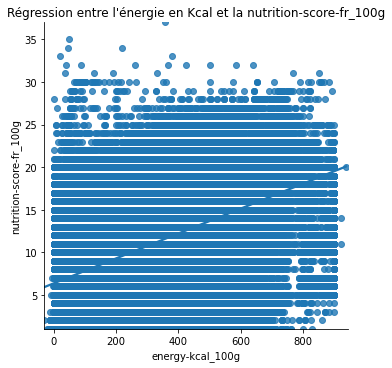

In [463]:
sns.lmplot(x="energy-kcal_100g", y="nutrition-score-fr_100g", data=df2)
plt.title("Régression entre l'énergie en Kcal et la nutrition-score-fr_100g")
plt.xlim(df2["energy-kcal_100g"].min(), df2["energy-kcal_100g"].max())
plt.ylim(df2["nutrition-score-fr_100g"].min(), df2["nutrition-score-fr_100g"].max())
plt.show()

In [464]:
pg.linear_regression(X=df2["energy-kcal_100g"], y=df2["nutrition-score-fr_100g"], add_intercept=True, remove_na=True, alpha=0.05)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,6.358907,0.015395,413.048382,0.0,0.180922,0.18092,6.328733,6.389081
1,energy-kcal_100g,0.014620,0.000048,302.021324,0.0,0.180922,0.18092,0.014526,0.014715


#### - Nutrition-score-fr_100g et la quantité de graisses pour 100g

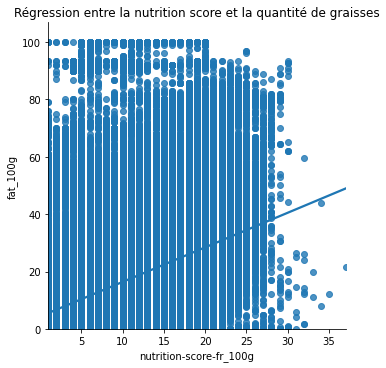

In [465]:
sns.lmplot(x="nutrition-score-fr_100g", y="fat_100g", data=df2)
plt.title("Régression entre la nutrition score et la quantité de graisses")
plt.xlim(df2["nutrition-score-fr_100g"].min(), df2["nutrition-score-fr_100g"].max())
plt.ylim(df2["fat_100g"].min(), df2["fat_100g"].max())
plt.show()

In [466]:
pg.linear_regression(X=df2["nutrition-score-fr_100g"], y=df2["fat_100g"], add_intercept=True, remove_na=True, alpha=0.05)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,4.308851,0.053530,80.494110,0.0,0.150844,0.150842,4.203934,4.413768
1,nutrition-score-fr_100g,1.206180,0.004453,270.847919,0.0,0.150844,0.150842,1.197451,1.214908


#### - Nutrition-score-fr_100g et la quantité de graisses saturées pour 100g

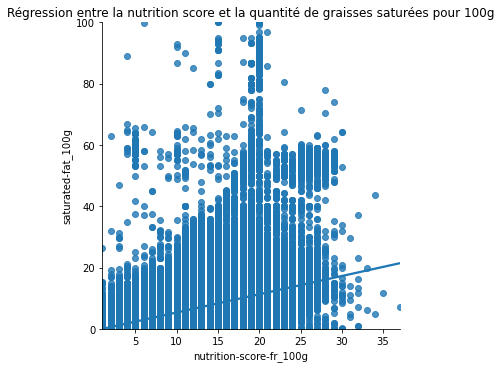

In [467]:
sns.lmplot(x="nutrition-score-fr_100g", y="saturated-fat_100g", data=df2)
plt.title("Régression entre la nutrition score et la quantité de graisses saturées pour 100g")
plt.xlim(df2["nutrition-score-fr_100g"].min(), df2["nutrition-score-fr_100g"].max())
plt.ylim(df2["saturated-fat_100g"].min(), df2["saturated-fat_100g"].max())
plt.show()

In [469]:
pg.linear_regression(X=df2["nutrition-score-fr_100g"], y=df2["saturated-fat_100g"], add_intercept=True, remove_na=True, alpha=0.05)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-0.600223,0.018526,-32.399596,5.419597e-230,0.265295,0.265293,-0.636533,-0.563913
1,nutrition-score-fr_100g,0.595148,0.001541,386.155893,0.000000e+00,0.265295,0.265293,0.592127,0.598169


On montre les catégories de produits ayant le plus de richesse en variables cibles

Top10 des meilleurs catégories par rapport aux variables cibles

In [551]:
# Définir un nouvelle colonne dans datafarme en filtrant sur nombre des graisses et de la sucre et  dusalt et des carbohydrats
df['produit_riche'] = df[['fat_100g','saturated-fat_100g','carbohydrates_100g', 'sugars_100g', 'salt_100g']].sum(axis=1)

Text(0, 0.5, 'Classement des produit par fat/salt/sugar/carbohydrates')

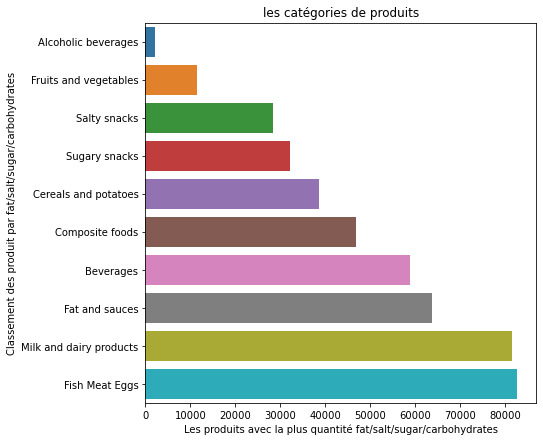

In [553]:
# Selctioner des valeurs en limitand de produit unknown
df_categorie = df[df['pnns_groups_1'] != 'unknown']
# Sorting et choisir les tops catégories de produits qui sont les moins valeurs (moin gras)
#top_categorie = df_categorie.sort_values('produit_riche', ascending=True).head(50)
top_categorie = df_categorie.groupby('pnns_groups_1')['produit_riche'].count().sort_values(ascending=True)
# Donnez la liste des catégories les mieux classés par rapport à la quantité de graisses
plt.figure(figsize=(7,7))
plt.title('les catégories de produits')
sns.barplot(x=top_categorie[:50], y=top_categorie.index)
plt.xlabel("Les produits avec la plus quantité fat/salt/sugar/carbohydrates")
plt.ylabel('Classement des produit par fat/salt/sugar/carbohydrates')

Text(0, 0.5, 'Classement des produit par fat/salt/sugar/carbohydrates')

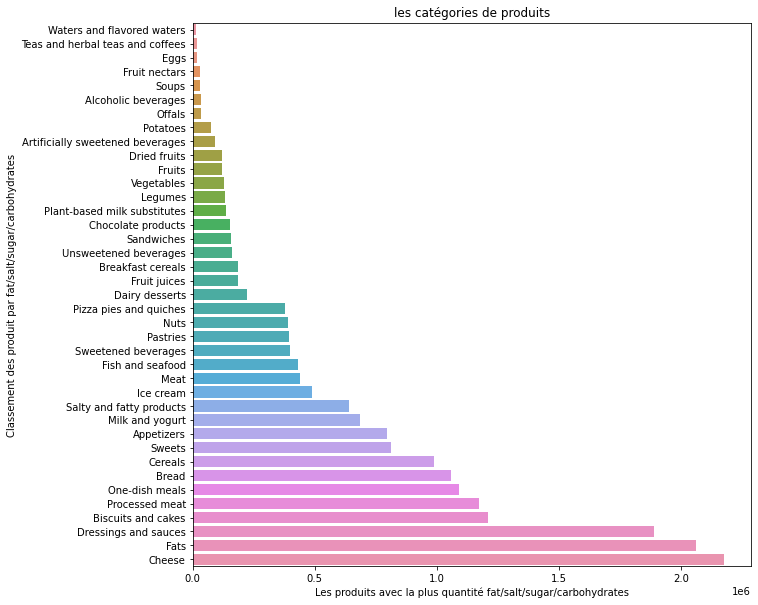

In [424]:
# Selctioner des valeurs en limitand de produit unknown
df_categorie = df[df['pnns_groups_2'] != 'unknown']
# Sorting et choisir les tops catégories de produits qui sont les moins valeurs (moin gras)
#top_categorie = df_categorie.sort_values('produit_riche', ascending=True).head(50)
top_categorie = df_categorie.groupby('pnns_groups_2')['produit_riche'].sum().sort_values(ascending=True)
# Donnez la liste des catégories les mieux classés par rapport à la quantité de graisses
plt.figure(figsize=(10,10))
plt.title('les catégories de produits')
sns.barplot(x=top_categorie[:50], y=top_categorie.index)
plt.xlabel("Les produits avec la plus quantité fat/salt/sugar/carbohydrates")
plt.ylabel('Classement des produit par fat/salt/sugar/carbohydrates')

Text(0, 0.5, 'Classement des produit par fat/salt/sugar/carbohydrates')

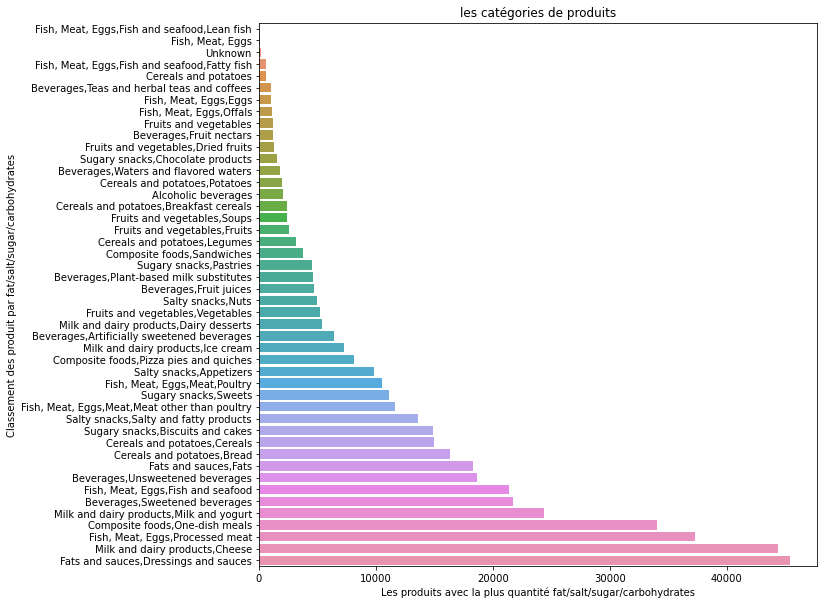

In [425]:
# Selctioner des valeurs en limitand de produit unknown
df_food_groups = df[df['food_groups_en'] != 'unknown']
# Sorting et choisir les tops catégories de produits qui sont les moins valeurs (moin gras)
top_food_groups = df_food_groups.groupby('food_groups_en')['produit_riche'].count().sort_values(ascending=True)
# Donnez la liste des catégories les mieux classés par rapport à la quantité de graisses
plt.figure(figsize=(10,10))
plt.title('les catégories de produits')
sns.barplot(x=top_food_groups[:50], y=top_food_groups.index)
plt.xlabel("Les produits avec la plus quantité fat/salt/sugar/carbohydrates")
plt.ylabel('Classement des produit par fat/salt/sugar/carbohydrates')

Top 30 des meilleurs marques

Text(0.5, 0, 'Classement des marques par des produits riche des fat/salt/sugar/carbohydrates')

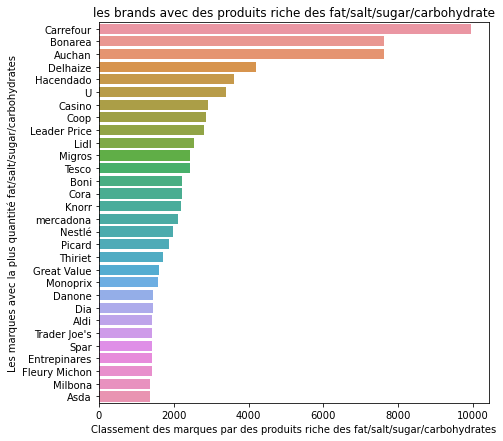

In [426]:
# Selctioner des valeurs en limitand des marques unknown
df_brands = df[df['brands'] != 'unknown']
# Sorting et choisir les tops marques avec des produits qui ont plus quantité fat/salt/sugar/carbohydrates
#top_brands = df_brands.sort_values('produit_riche', ascending=True).head(30)
top_brands = df_brands.groupby('brands')['produit_riche'].count().sort_values(ascending=False).head(30)
# Donnez la liste des marques les mieux classés par rapport à la quantité fat/salt/sugar/carbohydrates 
plt.figure(figsize=(7,7))
plt.title('les brands avec des produits riche des fat/salt/sugar/carbohydrate')
sns.barplot(x=top_brands[:30], y=top_brands.index)
plt.ylabel("Les marques avec la plus quantité fat/salt/sugar/carbohydrates")
plt.xlabel('Classement des marques par des produits riche des fat/salt/sugar/carbohydrates')

Top3 des meilleurs pays

Text(0.5, 0, 'Classement des pays par des produits riche des fat/salt/sugar/carbohydrates')

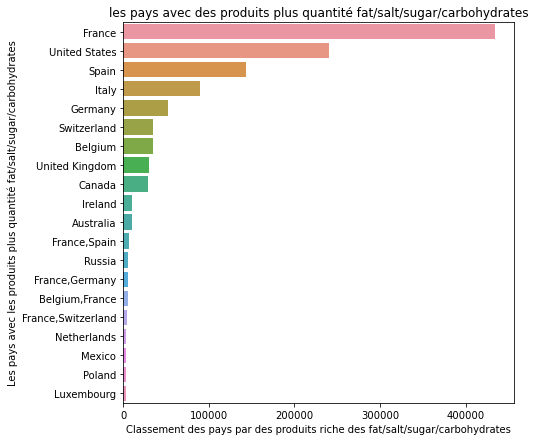

In [427]:
# Selctioner des valeurs en limitand de pays unknown
df_pays = df[df['countries_en'] != 'unknown']
# Sorting et choisir les tops pays avec des produits qui ont plus quantité fat/salt/sugar/carbohydrates

top_pays = df_pays.groupby('countries_en')['produit_riche'].count().sort_values(ascending=False).head(20)
# Donnez la liste des marques les mieux classés par rapport à la quantité fat/salt/sugar/carbohydrates 
plt.figure(figsize=(7,7))
plt.title('les pays avec des produits plus quantité fat/salt/sugar/carbohydrates')
sns.barplot(x=top_pays[:20], y=top_pays.index)
plt.ylabel("Les pays avec les produits plus quantité fat/salt/sugar/carbohydrates")
plt.xlabel('Classement des pays par des produits riche des fat/salt/sugar/carbohydrates')

# Création un score général pour les produits les pays différentes 


On utilise un classement par quartiles un score entre 0 et 3 pour chaque valeurs ingredients afin de noter le critère indicateur de chaque produit (3 pour la produit avec plus fat/saturated fat/sugars/salt/energy , 0 pour la moins fat/saturated fat/sugars/salt/energy).

In [498]:
df['Score_energy-kcal_100g'] = pd.qcut(df['energy-kcal_100g'], 4, labels = False,duplicates='drop')
df['Score_fat_100g'] = pd.qcut(df['fat_100g'], 4, labels = False,duplicates='drop')
df['Score_saturated-fat_100g'] = pd.qcut(df['saturated-fat_100g'], 4, labels = False,duplicates='drop')
df['Score_carbohydrates_100g'] = pd.qcut(df['carbohydrates_100g'], 4, labels = False,duplicates='drop')
df['Score_sugars_100g'] = pd.qcut(df['sugars_100g'], 4, labels = False,duplicates='drop')
df['Score_salt_100g'] = pd.qcut(df['salt_100g'], 4, labels = False,duplicates='drop')
df["Score_Total"] = (df["Score_energy-kcal_100g"] + df['Score_fat_100g'] + df['Score_saturated-fat_100g'] + df['Score_carbohydrates_100g'] + df['Score_sugars_100g'] + df['Score_salt_100g']) / 6

Text(0, 0.5, 'Classement des produit')

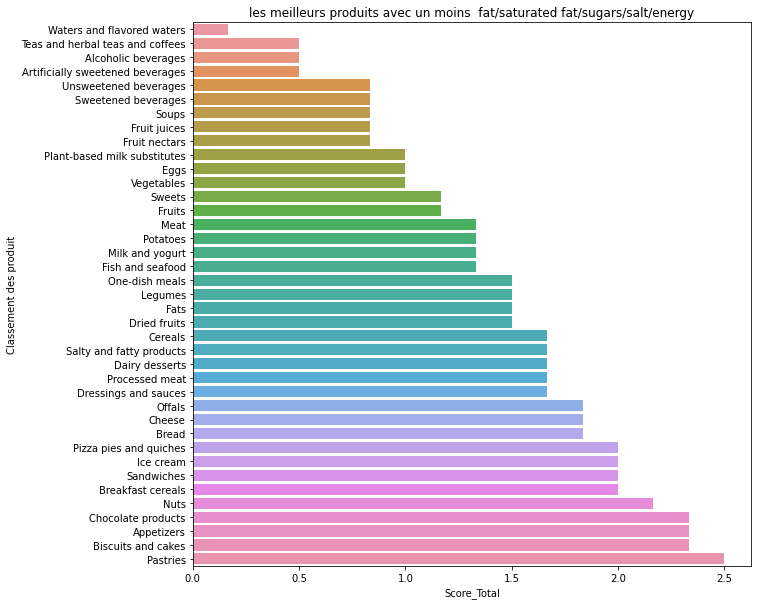

In [499]:
#Filtre pour les produit avec moin score
df_limit_score = df[(df['Score_Total'] <= 3) & (df['pnns_groups_2'] != 'unknown')]
#top30_produit = data_limit.groupby('product_name')['Score_Total']
#top50_produit = df_limit_score.sort_values('Score_Total', ascending=True)
top50_produit = df_limit_score.groupby('pnns_groups_2')['Score_Total'].median().sort_values(ascending=True)
# plot- les meilleurs produits avec un moins  fat/saturated fat/sugars/salt/energy
plt.figure(figsize=(10, 10))
plt.title('les meilleurs produits avec un moins  fat/saturated fat/sugars/salt/energy')
sns.barplot(x=top50_produit[:100], y=top50_produit.index)
#sns.barplot(x=top50_produit['Score_Total'], y=top50_produit['pnns_groups_2'])
plt.ylabel('Classement des produit')

# ACP et réduction de dimensions

In [500]:
features = ['energy-kcal_100g', 'fat_100g','saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'salt_100g', 'proteins_100g']
df_nutri = df[features]

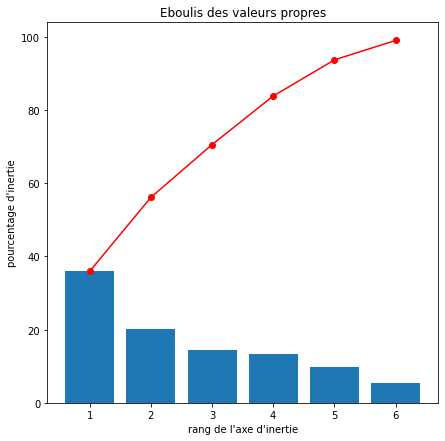

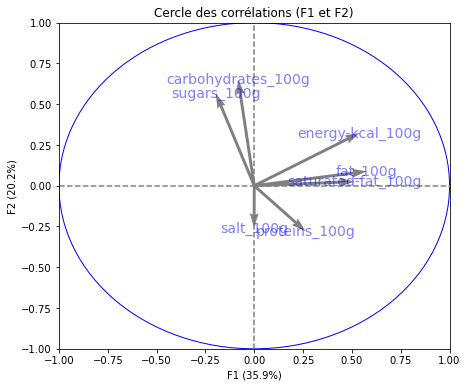

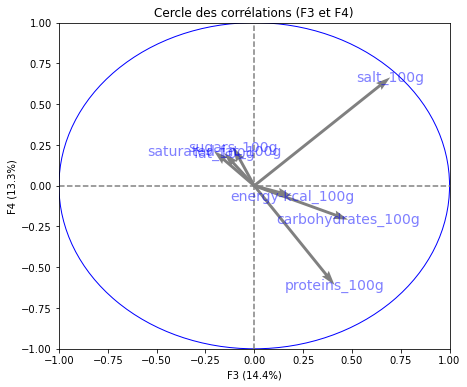

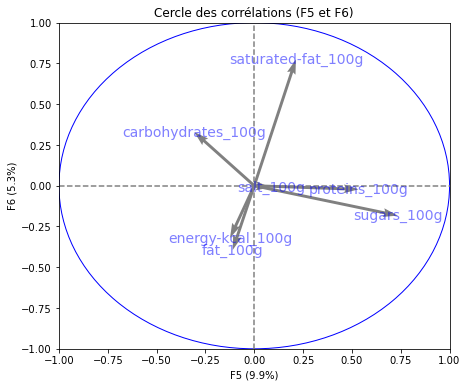

<Figure size 504x504 with 0 Axes>

In [575]:
from sklearn import preprocessing
from sklearn import decomposition
from functions import *
plt.figure(figsize=(7, 7))
# Centrage et réducation
n_comp = 6 
std_scale = preprocessing.StandardScaler().fit(df_nutri)
X_scaled = std_scale.transform(df_nutri)

# Calcul des composantes principales 
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))

# Projection des individus 

X_projected = pca.fit_transform(X_scaled)
#display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(df_france['nutriscore_grade']))
#df_proj = pd.DataFrame(X_projected, columns=['F'+str(i+1) for i in range(6)])
plt.show()

* F1 (36.7%) : Energie en calories et lipides et graisses saturées(fat et saturated_fat )

* F2 (24.3%) : Sel, Protéines, Fibres, Carbohydrates, Sucre

=> 61% de variance expliquée

In [502]:
df_proj = pd.DataFrame(X_projected, columns=['F'+str(i+1) for i in range(6)])
df_proj['nutriscore_grade'] = df['nutriscore_grade']
df_proj['pnns_groups_1'] = df['pnns_groups_1']
df_proj['food_groups_en'] = df['food_groups_en']
df_proj['Score_Total'] = df['Score_Total']

<AxesSubplot:xlabel='F1', ylabel='F5'>

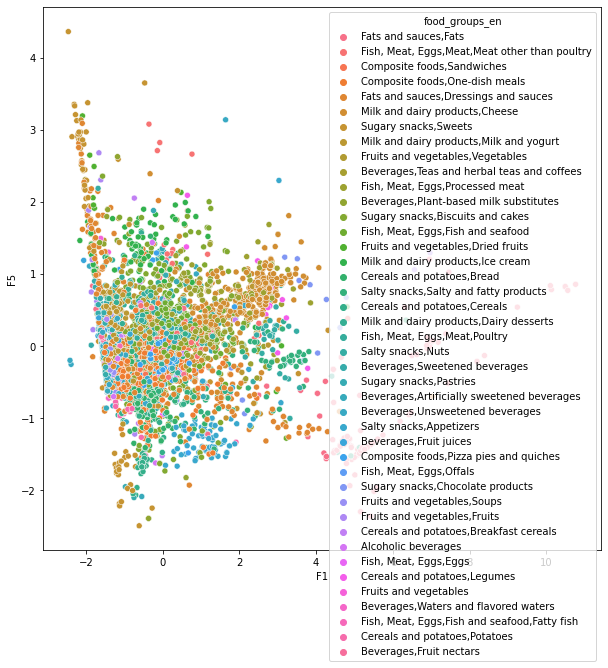

In [572]:
df_sample = df_proj.sample(frac=0.01)
df_sample = df_sample[df_sample['food_groups_en'] != 'unknown']
plt.figure(figsize=(10,10))
sns.scatterplot(df_sample.iloc[:,0], df_sample.iloc[:,4], df_sample['food_groups_en'])

<AxesSubplot:xlabel='F1', ylabel='F5'>

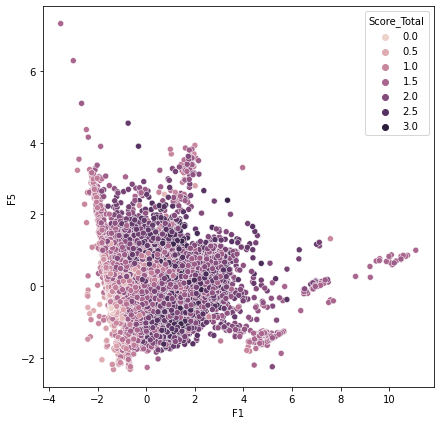

In [570]:
df_sample = df_proj.sample(frac=0.01)
plt.figure(figsize=(7,7))
sns.scatterplot(df_sample.iloc[:,0], df_sample.iloc[:,4], df_sample['Score_Total'])

<AxesSubplot:xlabel='F1', ylabel='F5'>

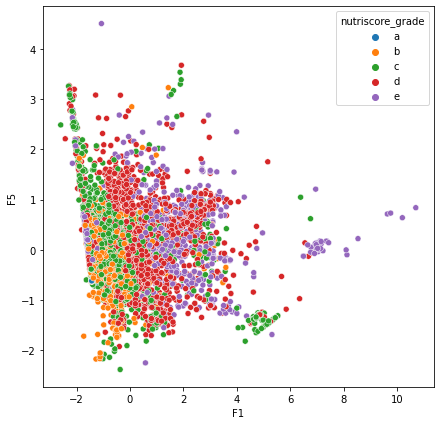

In [540]:
df_sample = df_proj.sample(frac=0.01)
df_sample = df_sample[df_sample['nutriscore_grade'] != 'unknown']
plt.figure(figsize=(7,7))
sns.scatterplot(df_sample.iloc[:,0], df_sample.iloc[:,4], df_sample['nutriscore_grade'], hue_order=['a', 'b', 'c', 'd', 'e'])


<AxesSubplot:xlabel='F1', ylabel='F5'>

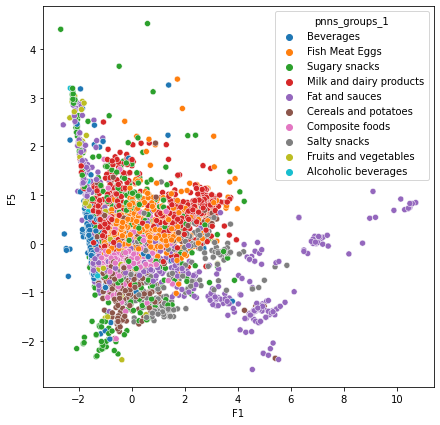

In [569]:
df_sample = df_proj.sample(frac=0.01)
df_sample = df_sample[df_sample['pnns_groups_1'] != 'unknown']
plt.figure(figsize=(7,7))
plt.title("")
sns.scatterplot(df_sample.iloc[:,0], df_sample.iloc[:,4], df_sample['pnns_groups_1'])

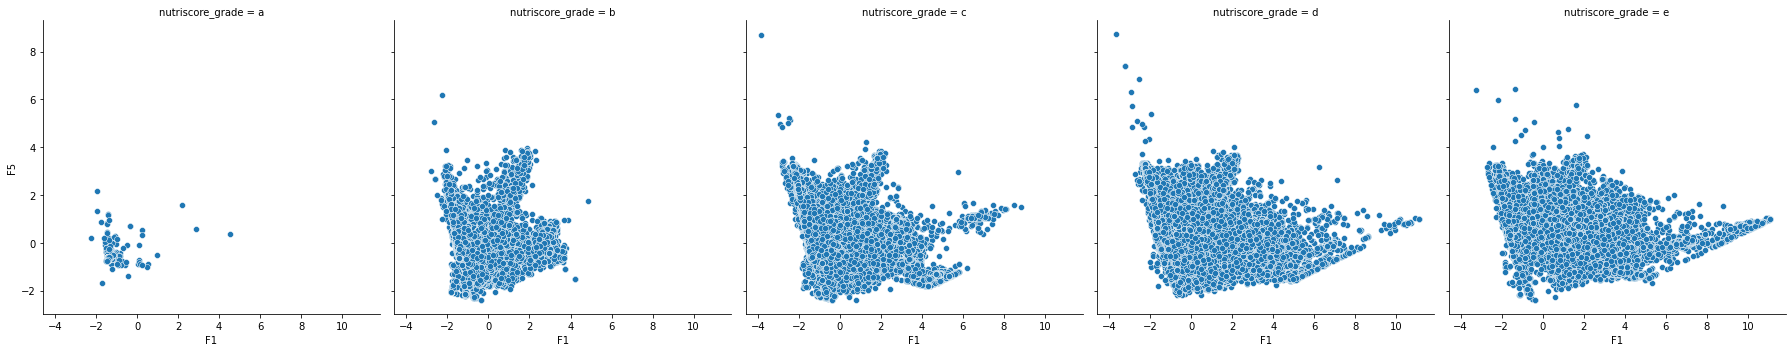

In [547]:
sns.relplot(data= df_proj, x='F1', y='F5', col='nutriscore_grade', col_order=['a', 'b', 'c', 'd', 'e'], kind='scatter')


# Test de Kruskal Wallis


In [581]:
from scipy import stats
list_var = []
for note in ['a', 'b', 'c', 'd', 'e']:
    filtre_grade = df['nutriscore_grade'] == note
    list_var.append(df[filtre_grade]['Score_Total'].tolist())
stats.kruskal(*list_var)
    

KruskalResult(statistic=123290.49942947426, pvalue=0.0)

In [577]:
df.to_csv("finalfile")

# Proposer le produit

On définit une fonction afin de nous proposer les meilleurs produit francais dans la catégorie qu'on cherche.

In [137]:
def find_best(df, product_name):
    filter_product = df['product_name'].str.contains(product_name)
    products = df[filter_product]
    products_sorted = products['Score_Total'].sort_values(ascending=True)
    return products.loc[products_sorted.index]

<AxesSubplot:xlabel='Score_Total', ylabel='product_name'>

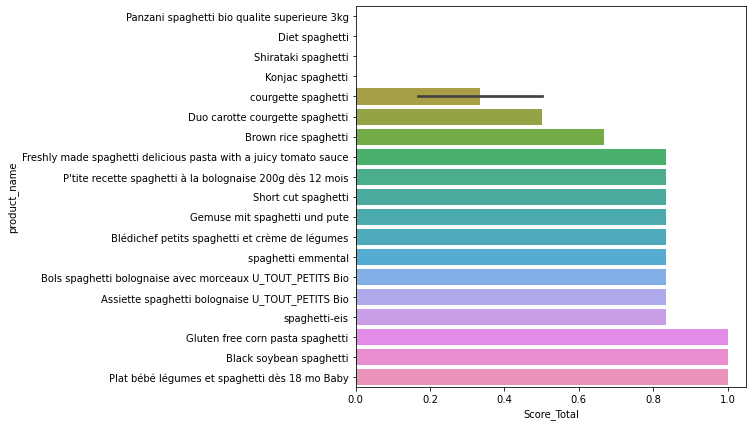

In [566]:
best_produit = find_best(df_france.dropna(subset=['product_name']), 'spaghetti').head(20)
plt.figure(figsize=(7,7))
sns.barplot(x=best_produit['Score_Total'], y=best_produit['product_name'])

<AxesSubplot:xlabel='Score_Total', ylabel='brands'>

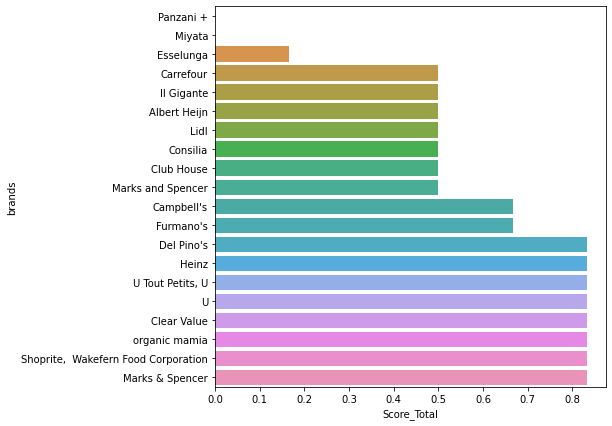

In [568]:
df_brands = df[df['brands'] != 'unknown']
best_produit = find_best(df_brands.dropna(subset=['brands']), 'spaghetti').head(20)
plt.figure(figsize=(7,7))
sns.barplot(x=best_produit['Score_Total'], y=best_produit['brands'])

# Création un score général pour les produits français et proposer le produit français

#### Limite le  jeu de donnée pour la France

Pour la suite de notre étude, on va se pencher sur l'analyse des données uniquement pour la France.

In [430]:
df_france = df.loc[df['countries_en'] == 'France']
df_france.shape

(434760, 31)

In [139]:
df_france.head(5)

,code,product_name,brands,categories,countries_en,additives_n,ingredients_that_may_be_from_palm_oil_n,nutriscore_grade,nova_group,pnns_groups_1,...,sum_ingredients,produit_riche,Score_energy-kcal_100g,Score_fat_100g,Score_saturated-fat_100g,Score_carbohydrates_100g,Score_sugars_100g,Score_salt_100g,Score_Total,Score_Total_france
0,3660088110779,Sardines sans arêtes à l’huile d’olive,LA BELLE ILOISE,"Conserves, Produits de la mer, Poissons, Poiss...",France,0.0,0.0,d,3.0,Fish Meat Eggs,...,50.7,34.74,3,3,2,0,0,1,1.500000,1.500000
2,3263851162311,Moutarde moût de raisin,Franprix,"Epicerie, Condiments, Sauces, Moutardes",France,0.0,0.0,d,3.0,Fat and sauces,...,69.19999999999999,66.30,2,1,1,3,3,3,2.166667,2.166667
3,3263851162410,Moutarde,Franprix,"Epicerie, Condiments, Sauces, Moutardes, Mouta...",France,1.0,0.0,d,4.0,Fat and sauces,...,81.80000000000001,78.10,2,1,0,3,3,3,2.000000,2.000000
4,3263851162519,Sauce vinaigrette tomates séchées,Franprix,"Epicerie, Sauces, Sauces salades, Vinaigrettes",France,0.0,0.0,d,3.0,Fat and sauces,...,57.800000000000004,61.00,3,3,2,0,1,3,2.000000,2.000000
11,3263851127556,"Soupe Chinoise aux Nouilles, Champignons Noirs...",Leader Price (Délices Du Monde),"Plats préparés, Soupes",France,0.0,0.0,c,4.0,Composite foods,...,92.1,82.70,2,1,0,3,3,3,2.000000,2.000000


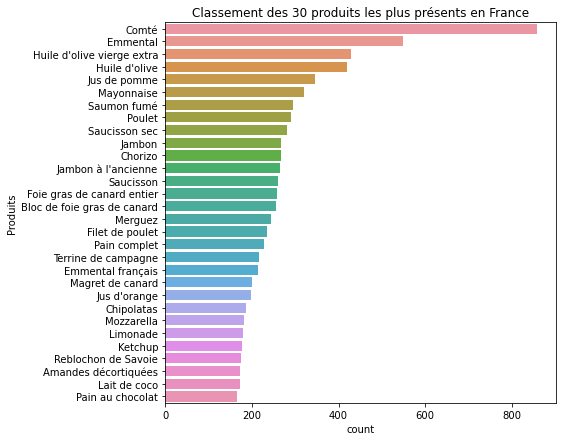

In [431]:
plt.figure(figsize=(7, 7))
sns.countplot(y="product_name", data=df_france, order=pd.value_counts(df_france['product_name']).iloc[:30].index)
plt.ylabel("Produits")
plt.title("Classement des 30 produits les plus présents en France")
plt.show()

Création score pour les produits français

In [554]:
df_france['Score_energy-kcal_100g'] = pd.qcut(df_france['energy-kcal_100g'], 4, labels = False,duplicates='drop')
df_france['Score_fat_100g'] = pd.qcut(df_france['fat_100g'], 4, labels = False,duplicates='drop')
df_france['Score_saturated-fat_100g'] = pd.qcut(df_france['saturated-fat_100g'], 4, labels = False,duplicates='drop')
df_france['Score_carbohydrates_100g'] = pd.qcut(df_france['carbohydrates_100g'], 4, labels = False,duplicates='drop')
df_france['Score_sugars_100g'] = pd.qcut(df_france['sugars_100g'], 4, labels = False,duplicates='drop')
df_france['Score_salt_100g'] = pd.qcut(df_france['salt_100g'], 4, labels = False,duplicates='drop')

On fait la moyenne des scores

In [555]:
df_france["Score_Total_france"] = (df_france["Score_energy-kcal_100g"] + df_france['Score_fat_100g'] + df_france['Score_saturated-fat_100g'] + df_france['Score_carbohydrates_100g'] + df_france['Score_sugars_100g'] + df_france['Score_salt_100g']) / 6


Text(0, 0.5, 'Classement des produit')

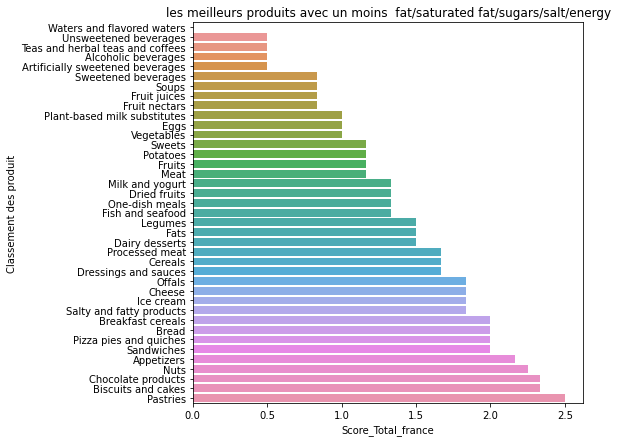

In [556]:
#Filtre pour les produit avec moin score
df_limit_score = df_france[(df_france['Score_Total_france'] <= 3) & (df_france['pnns_groups_2'] != 'unknown')]
#top30_produit = data_limit.groupby('product_name')['Score_Total']
#top50_produit = df_limit_score.sort_values('Score_Total', ascending=True)
top50_produit = df_limit_score.groupby('pnns_groups_2')['Score_Total_france'].median().sort_values(ascending=True)
# plot- les meilleurs produits avec un moins  fat/saturated fat/sugars/salt/energy
plt.figure(figsize=(7, 7))
plt.title('les meilleurs produits avec un moins  fat/saturated fat/sugars/salt/energy')
sns.barplot(x=top50_produit[:40], y=top50_produit.index)
#sns.barplot(x=top50_produit['Score_Total'], y=top50_produit['pnns_groups_2'])
plt.ylabel('Classement des produit')

<AxesSubplot:title={'center':'Classement des produits français par nutriscore'}, xlabel='nutriscore_grade', ylabel='count'>

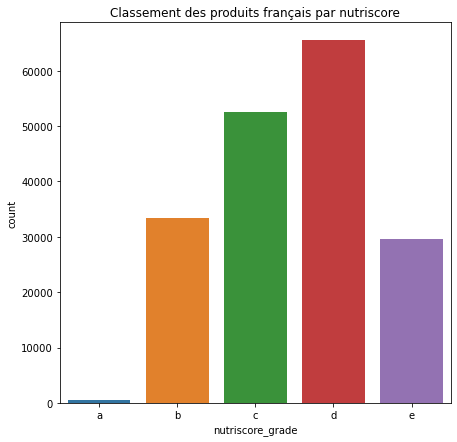

In [558]:
plt.figure(figsize=(7,7))
plt.title("Classement des produits français par nutriscore")
sns.countplot(x='nutriscore_grade', data=df_france, order=['a', 'b', 'c', 'd', 'e'])

## Proposer les produits français

On définit une fonction afin de nous proposer les meilleurs produit francais dans la catégorie qu'on cherche

In [559]:
def find_best_france(df_france, product_name):
    filter_product = df_france['product_name'].str.contains(product_name)
    products = df_france[filter_product]
    products_sorted = products['Score_Total'].sort_values(ascending=True)
    return products.loc[products_sorted.index]

<AxesSubplot:xlabel='Score_Total', ylabel='product_name'>

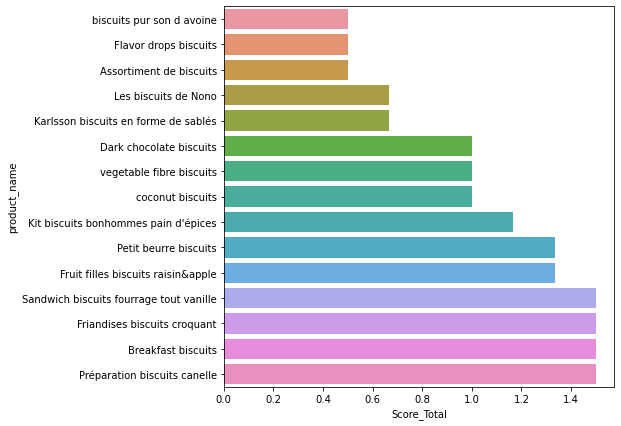

In [560]:
best_biscuits_france = find_best_france(df_france.dropna(subset=['product_name']), 'biscuits').head(15)
plt.figure(figsize=(7,7))
sns.barplot(x=best_biscuits_france['Score_Total'], y=best_biscuits_france['product_name'])

<AxesSubplot:xlabel='Score_Total', ylabel='brands'>

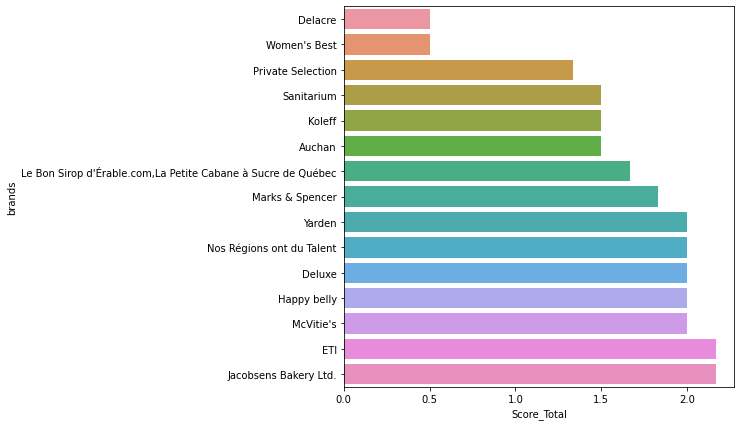

In [562]:
df_brands = df_france[df_france['brands'] != 'unknown']
best_biscuits_france = find_best_france(df_brands.dropna(subset=['brands']), 'biscuits').head(15)
plt.figure(figsize=(7,7))
sns.barplot(x=best_biscuits_france['Score_Total'], y=best_biscuits_france['brands'])